### Import Libraries

In [836]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.dates as mdates
import matplotlib.ticker as mtick

### Configure Settings

In [837]:
pd.set_option('display.max_columns', None)
%matplotlib inline
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

### Load datasets

In [838]:
raw_customers = pd.read_csv('../data/customer_signups.csv')
customers = pd.read_csv('../data/customer_signups.csv')
tickets = pd.read_csv('../data/support_tickets.csv')

print(f"Signups: {customers.shape}")
print(f"Tickets: {tickets.shape}")

Signups: (300, 10)
Tickets: (123, 5)


### Data Exploration

In [839]:
customers.head()
customers.info()
customers.describe(include='all')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 300 entries, 0 to 299
Data columns (total 10 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   customer_id       298 non-null    object
 1   name              291 non-null    object
 2   email             266 non-null    object
 3   signup_date       298 non-null    object
 4   source            291 non-null    object
 5   region            270 non-null    object
 6   plan_selected     292 non-null    object
 7   marketing_opt_in  290 non-null    object
 8   age               288 non-null    object
 9   gender            292 non-null    object
dtypes: object(10)
memory usage: 23.6+ KB


,customer_id,name,email,signup_date,source,region,plan_selected,marketing_opt_in,age,gender
count,298,291,266,298,291,270,292,290,288,292
unique,298,291,265,295,7,5,8,3,11,7
top,CUST00000,Joshua Bryant,lisa11@mailhub.org,not a date,YouTube,North,Premium,No,40,Other
freq,1,1,2,4,58,65,57,156,50,59


In [840]:
tickets.head()
tickets.info()
tickets.describe(include='all')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 123 entries, 0 to 122
Data columns (total 5 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   ticket_id    123 non-null    object
 1   customer_id  123 non-null    object
 2   ticket_date  123 non-null    object
 3   issue_type   123 non-null    object
 4   resolved     123 non-null    object
dtypes: object(5)
memory usage: 4.9+ KB


,ticket_id,customer_id,ticket_date,issue_type,resolved
count,123,123,123,123,123
unique,123,60,99,5,2
top,TKT0000-1,CUST00203,2024-04-07,Login Issue,Yes
freq,1,3,3,29,103


### Data Cleaning

#### Convert signup_date to datetime

In [867]:
invalid_dates = customers[
    pd.to_datetime(customers['signup_date'], errors='coerce').isna()
]
print("Invalid signup_date entries:")
display(invalid_dates[['signup_date']])


customers['signup_date'] = customers['signup_date'].replace('not a date', np.nan)
customers['signup_date'] = pd.to_datetime(customers['signup_date'], errors='coerce')


print(f"Valid dates: {customers['signup_date'].notna().sum()}")
print(f"Invalid dates: {customers['signup_date'].isna().sum()}")

display(customers.loc[0, 'signup_date'])

Invalid signup_date entries:


,signup_date
0,NaT
80,NaT
120,NaT
159,NaT
197,NaT
217,NaT


Valid dates: 294
Invalid dates: 6


NaT

#### Standardize inconsistent text values & Handle missing values

In [868]:
cat_cols = customers.select_dtypes(include=['object','datetime64','bool']).columns
cat_cols

for col in cat_cols:
    print(f"\n--- {col} ---")
    print(customers[col].value_counts(dropna=False))


--- customer_id ---
customer_id
CUST00000    1
CUST00206    1
CUST00204    1
CUST00203    1
CUST00202    1
            ..
CUST00099    1
CUST00098    1
CUST00097    1
CUST00096    1
CUST00299    1
Name: count, Length: 300, dtype: int64

--- name ---
name
NaN                  9
Joshua Bryant        1
Kimberly Jackson     1
Brian Hicks          1
Patricia Powers      1
                    ..
Chelsey Rodriguez    1
Wayne Hopkins        1
Bryan George         1
Michelle Mcguire     1
Bruce Bridges        1
Name: count, Length: 292, dtype: int64

--- email ---
email
NaN                        34
lisa11@mailhub.org          2
jessica97@mailhub.org       1
kevin3@mailhub.org          1
donald2@example.com         1
                           ..
hannah6@example.com         1
cindy7@mailhub.org          1
margaret9@example.com       1
katherine10@example.com     1
mr.99@example.com           1
Name: count, Length: 266, dtype: int64

--- signup_date ---
signup_date
NaT           6
2024-02-02   

##### customer_id

In [843]:
customers['customer_id'] = customers['customer_id'].astype(str).str.strip()

customers['customer_id'] = customers['customer_id'].replace({'nan': np.nan})

##### name

In [844]:
customers['name'] = (
    customers['name']
    .astype(str)
    .str.replace(r'^(Mr\.|Mrs\.|Ms\.|Miss)\s+', '', regex=True)
    .str.title()
    .replace({'Nan': np.nan})
)

##### email

In [845]:
customers['email'] = (
    customers['email']
    .astype(str)
    .str.strip()
    .str.lower()
    .replace({'nan': np.nan})
)

customers['email_missing'] = customers['email'].isna()


##### source

In [846]:
source_map = {
    'Youtube': 'YouTube',
    'Linkedin': 'LinkedIn',
    '??': 'Unknown',
    np.nan: 'Unknown',
    'Nan': np.nan
}

customers['source'] = (
    customers['source']
    .astype(str)
    .str.strip()
    .str.title()
    .replace(source_map)
)

##### region

In [847]:
customers['region'] = (
    customers['region']
    .astype(str)
    .str.strip()
    .str.title()
    .replace({'Nan': np.nan})
)

customers['region'] = customers['region'].fillna('Unknown')
customers['region_missing'] = customers['region'] == 'Unknown'

##### plan_selected

In [848]:
plan_map = {
    'basic': 'Basic',
    'Basic': 'Basic',
    'pro': 'Pro',
    'Pro': 'Pro',
    'premium': 'Premium',
    'Premium': 'Premium',
    'PREMIUM': 'Premium',
    'PRO': 'Pro',
    'prem': 'Premium',
    'Unknownplan': 'Unknown'
}

customers['plan_selected'] = (
    customers['plan_selected']
    .astype(str)
    .str.strip()
    .replace(plan_map)
    .replace({'nan': np.nan})
)

##### marketing_opt_in

In [849]:
customers['marketing_opt_in'] = (
    customers['marketing_opt_in']
    .astype(str)
    .str.strip()
    .str.title()
    .replace({'Nil': np.nan, 'Nan': np.nan})
)

##### age

In [850]:
customers['age'] = customers['age'].replace({'unknown': np.nan, 'thirty': '30'})

def clean_age(x):
    try:
        age = int(float(x))  
        if age < 16 or age > 100:
            return f"UNUSUAL_{age}"
        return age
    except:
        return np.nan

customers['age_cleaned'] = customers['age'].apply(clean_age)


def age_source(x):
    if pd.isna(x):
        return 'Missing'
    elif isinstance(x, str) and x.startswith('UNUSUAL'):
        return 'Unusual'
    else:
        return 'Original'

customers['age_source'] = customers['age_cleaned'].apply(age_source)


median_age = customers.loc[customers['age_source'] == 'Original', 'age_cleaned'].median()
customers.loc[customers['age_source'] == 'Missing', 'age_cleaned'] = median_age
customers.loc[customers['age_source'] == 'Missing', 'age_source'] = 'Imputed'


def finalize_age(x):
    if isinstance(x, str) and x.startswith('UNUSUAL'):
        return x
    else:
        return int(x)

customers['age_cleaned'] = customers['age_cleaned'].apply(finalize_age)

unusual_ages = customers[customers['age_source'] == 'Unusual']
print("Unusual ages detected:")
display(unusual_ages[['age', 'age_cleaned', 'age_source']])


Unusual ages detected:


,age,age_cleaned,age_source
204,206,UNUSUAL_206,Unusual


##### gender

In [851]:
gender_map = {
    'Male': 'Male',
    'male': 'Male',
    'Female': 'Female',
    'FEMALE': 'Female',
    'Non-Binary': 'Non-Binary',
    'Other': 'Other',
    '123': np.nan
}

customers['gender'] = (
    customers['gender']
    .astype(str)
    .str.strip()
    .replace(gender_map)
    .replace({'nan': np.nan})
)

#### Remove Duplicates

In [852]:
initial_count = len(customers)


non_null_ids = customers[customers['customer_id'].notna()].copy()
null_ids = customers[customers['customer_id'].isna()].copy()


duplicate_rows = non_null_ids[non_null_ids.duplicated(subset='customer_id', keep=False)]
duplicate_ids = duplicate_rows['customer_id'].unique()

print(f"Found {len(duplicate_ids)} duplicated customer_id(s): {duplicate_ids}")
display(duplicate_rows.sort_values('customer_id'))


non_null_ids = non_null_ids.drop_duplicates(subset='customer_id', keep='first')


if not null_ids.empty:
    
    existing_nums = (
        non_null_ids['customer_id']
        .str.extract(r'(\d+)$')[0]
        .astype(int)
    )

    start_num = existing_nums.max() + 1
    end_num = start_num + len(null_ids)

    new_ids = [f"CUST{num:05d}" for num in range(start_num, end_num)]
    null_ids['customer_id'] = new_ids

    print(f"Assigned new IDs to {len(null_ids)} missing entries, starting from {new_ids}")


customers = (
    pd.concat([non_null_ids, null_ids])
    .sort_index()
    .reset_index(drop=True)
)


duplicates_removed = initial_count - len(customers)
print(f"Removed {duplicates_removed} duplicate customer_id(s)")
print(f"Total customers after cleanup: {len(customers)}")

Found 0 duplicated customer_id(s): []


,customer_id,name,email,signup_date,source,region,plan_selected,marketing_opt_in,age,gender,email_missing,region_missing,age_cleaned,age_source


Assigned new IDs to 2 missing entries, starting from ['CUST00300', 'CUST00301']
Removed 0 duplicate customer_id(s)
Total customers after cleanup: 300


### Data Quality Summary

In [853]:
def combined_missing_summary(raw_df, clean_df):
    common_cols = [col for col in clean_df.columns if col in raw_df.columns]
    raw_missing = raw_df[common_cols].isna().sum()
    clean_missing = clean_df[common_cols].isna().sum()

    missing_df = pd.DataFrame({
        'Missing (Raw)': raw_missing,
        '% Missing (Raw)': (raw_missing / len(raw_df) * 100).round(2),
        'Missing (Cleaned)': clean_missing,
        '% Missing (Cleaned)': (clean_missing / len(clean_df) * 100).round(2),
    })

    missing_df['Change (Count)'] = missing_df['Missing (Raw)'] - missing_df['Missing (Cleaned)']
    missing_df['Change (%)'] = (
        missing_df['% Missing (Raw)'] - missing_df['% Missing (Cleaned)']
    ).round(2)

    missing_df = missing_df.sort_values('% Missing (Raw)', ascending=False)

    missing_df['Trend'] = np.where(
    missing_df['Change (Count)'] > 0, '🟢 Decreased',
    np.where(missing_df['Change (Count)'] < 0, '🔴 Increased', '⚪ No Change')
)


    print("\nCombined Missing Values Summary (Before vs After Cleaning):")
    display(missing_df)

    return missing_df


def category_comparison(raw_df, clean_df, cat_columns):
    print("\nCategory Value Comparison (Raw vs Cleaned):")
    comparison = {}

    for col in cat_columns:
        raw_vals = set(raw_df[col].dropna().astype(str).unique())
        clean_vals = set(clean_df[col].dropna().astype(str).unique())

        changed = raw_vals.symmetric_difference(clean_vals)
        mapping = {
            'Original (Raw)': sorted(list(raw_vals)),
            'After Cleaning': sorted(list(clean_vals)),
            'Changed Values': sorted(list(changed)) if changed else ['No Change']
        }

        comparison[col] = mapping

        print(f"\nColumn: {col}")
        print(f"Original (Raw): {mapping['Original (Raw)']}")
        print(f"After Cleaning: {mapping['After Cleaning']}")
        print(f"Changed Values: {mapping['Changed Values']}")

    return comparison


cat_columns = ['plan_selected','marketing_opt_in','gender','source','region']

combined_missing = combined_missing_summary(raw_customers, customers)
category_changes = category_comparison(raw_customers, customers, cat_columns)

numeric_ages = customers.loc[customers['age_source'].isin(['Original','Imputed']), 'age_cleaned']
unusual_ages = customers.loc[customers['age_source']=='Unusual','age_cleaned']

print("\nNumeric Age Summary (Cleaned):")
display(numeric_ages.value_counts().sort_index())

print("\nUnusual Ages Detected (Cleaned):")
display(unusual_ages.value_counts())



Combined Missing Values Summary (Before vs After Cleaning):


,Missing (Raw),% Missing (Raw),Missing (Cleaned),% Missing (Cleaned),Change (Count),Change (%),Trend
email,34,11.33,34,11.33,0,0.00,⚪ No Change
region,30,10.00,0,0.00,30,10.00,🟢 Decreased
age,12,4.00,18,6.00,-6,-2.00,🔴 Increased
marketing_opt_in,10,3.33,11,3.67,-1,-0.34,🔴 Increased
name,9,3.00,9,3.00,0,0.00,⚪ No Change
source,9,3.00,9,3.00,0,0.00,⚪ No Change
plan_selected,8,2.67,8,2.67,0,0.00,⚪ No Change
gender,8,2.67,14,4.67,-6,-2.00,🔴 Increased
customer_id,2,0.67,0,0.00,2,0.67,🟢 Decreased
signup_date,2,0.67,6,2.00,-4,-1.33,🔴 Increased



Category Value Comparison (Raw vs Cleaned):

Column: plan_selected
Original (Raw): ['Basic', 'PREMIUM', 'PRO', 'Premium', 'Pro', 'UnknownPlan', 'basic', 'prem']
After Cleaning: ['Basic', 'Premium', 'Pro', 'UnknownPlan']
Changed Values: ['PREMIUM', 'PRO', 'basic', 'prem']

Column: marketing_opt_in
Original (Raw): ['Nil', 'No', 'Yes']
After Cleaning: ['No', 'Yes']
Changed Values: ['Nil']

Column: gender
Original (Raw): ['123', 'FEMALE', 'Female', 'Male', 'Non-Binary', 'Other', 'male']
After Cleaning: ['Female', 'Male', 'Non-Binary', 'Other']
Changed Values: ['123', 'FEMALE', 'male']

Column: source
Original (Raw): ['??', 'Facebook', 'Google', 'Instagram', 'LinkedIn', 'Referral', 'YouTube']
After Cleaning: ['Facebook', 'Google', 'Instagram', 'LinkedIn', 'Referral', 'Unknown', 'YouTube']
Changed Values: ['??', 'Unknown']

Column: region
Original (Raw): ['Central', 'East', 'North', 'South', 'West']
After Cleaning: ['Central', 'East', 'North', 'South', 'Unknown', 'West']
Changed Values: ['U

age_cleaned
21    28
25    49
29    46
30     1
34    62
40    50
47    22
53    27
60    14
Name: count, dtype: int64


Unusual Ages Detected (Cleaned):


age_cleaned
UNUSUAL_206    1
Name: count, dtype: int64

### Summary Outputs

#### Sign-ups per Week

Sign-ups Per Week:


,signup_date,Signups
0,2024-01-07,6
1,2024-01-14,5
2,2024-01-21,7
3,2024-01-28,7
4,2024-02-04,8
5,2024-02-11,6
6,2024-02-18,6
7,2024-02-25,7
8,2024-03-03,7
9,2024-03-10,7


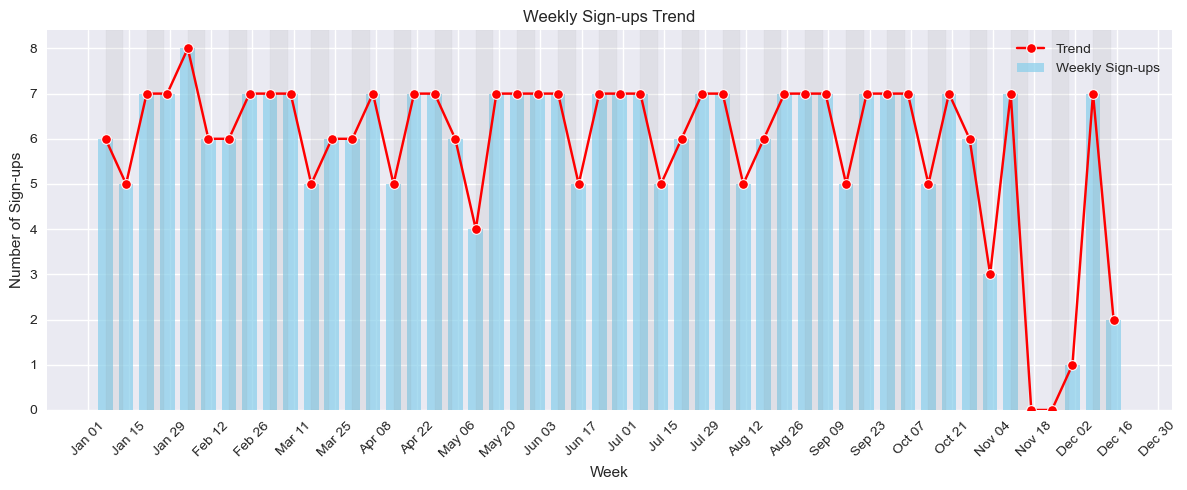

In [854]:
signups_per_week = (
    customers
    .set_index('signup_date')
    .resample('W')
    .size()
    .reset_index(name='Signups')
)

print("Sign-ups Per Week:")
display(signups_per_week)

plt.figure(figsize=(12,5))
plt.bar(signups_per_week['signup_date'], signups_per_week['Signups'], 
        width=5, color='skyblue', alpha=0.7, label='Weekly Sign-ups')
sns.lineplot(data=signups_per_week, x='signup_date', y='Signups', color='red', marker='o', label='Trend')

for i in range(0, len(signups_per_week), 2):
    plt.axvspan(signups_per_week['signup_date'][i], 
                signups_per_week['signup_date'][i]+pd.Timedelta(days=6), 
                color='gray', alpha=0.1)

plt.gca().xaxis.set_major_locator(mdates.WeekdayLocator(byweekday=mdates.MO, interval=2))
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%b %d'))

plt.title("Weekly Sign-ups Trend")
plt.xlabel("Week")
plt.ylabel("Number of Sign-ups")
plt.xticks(rotation=45)
plt.legend()
plt.tight_layout()
plt.show()


#### Sign-ups by source, region, and plan_selected

Sign-ups by Source, Region, and Plan:


,source,region,plan_selected,Signups
98,YouTube,South,Basic,9
91,YouTube,East,Basic,8
24,Google,North,Premium,7
58,LinkedIn,South,Basic,6
18,Google,Central,Pro,6
39,Instagram,North,Premium,6
26,Google,South,Basic,6
38,Instagram,North,Basic,5
36,Instagram,East,Premium,5
48,Instagram,West,Premium,5


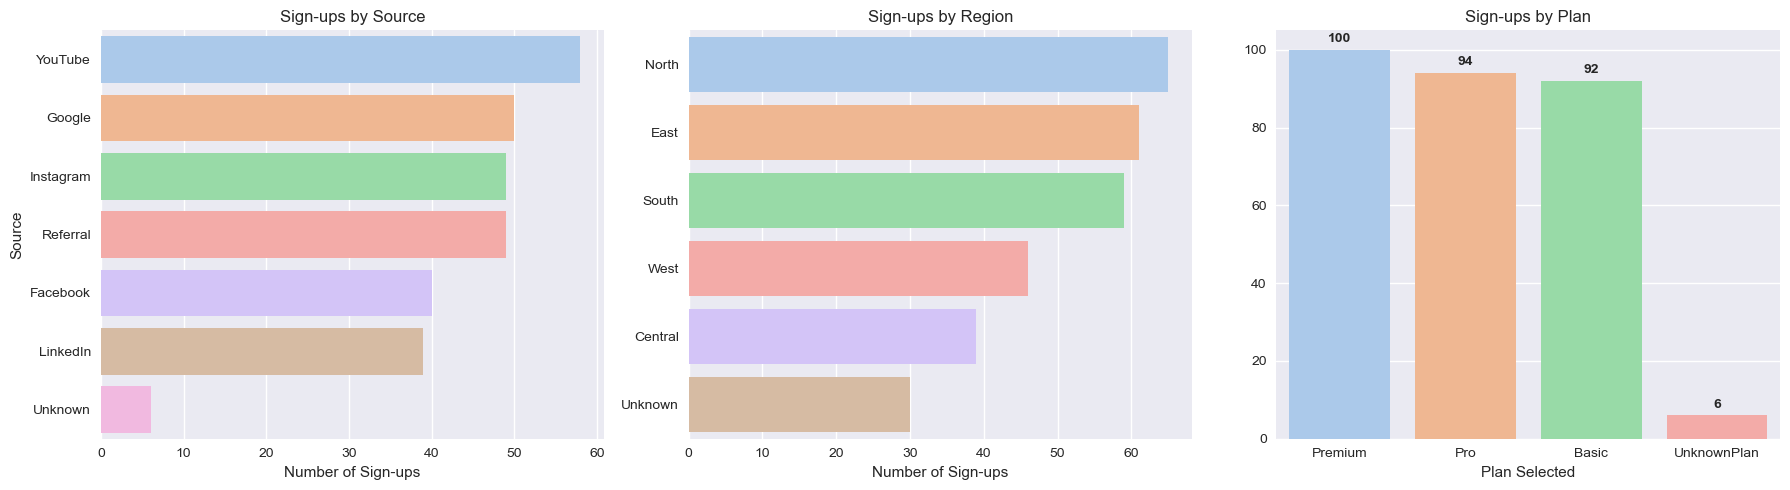

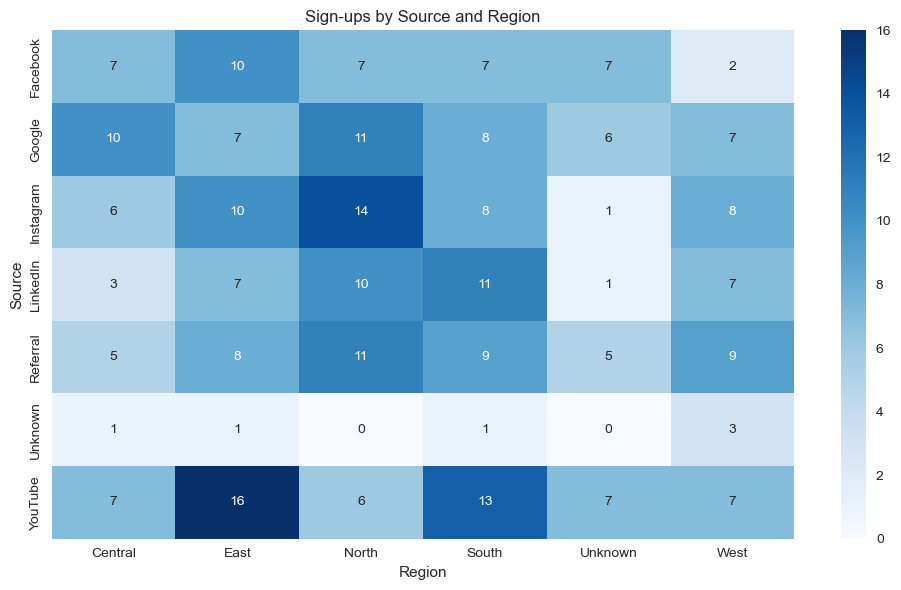

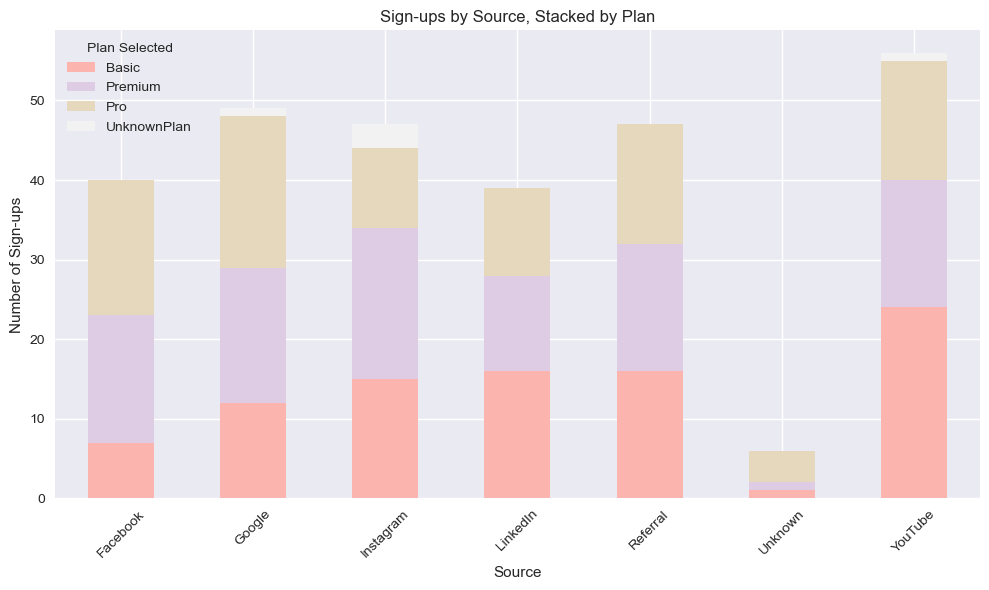

In [855]:
signups_by_factors = (
    customers.groupby(['source', 'region', 'plan_selected'])
    .size()
    .reset_index(name='Signups')
    .sort_values('Signups', ascending=False)
)

print("Sign-ups by Source, Region, and Plan:")
display(signups_by_factors.head(10))

top_sources = customers['source'].value_counts().reset_index()
top_sources.columns = ['Source', 'Signups']


region_counts = customers['region'].value_counts().reset_index()
region_counts.columns = ['Region', 'Signups']


plan_counts = customers['plan_selected'].value_counts().reset_index()
plan_counts.columns = ['Plan', 'Signups']

fig, axes = plt.subplots(1, 3, figsize=(18,5))

sns.barplot(
    data=top_sources, 
    x='Signups', 
    y='Source', 
    hue='Source', 
    dodge=False, 
    palette='pastel', 
    legend=False,
    ax=axes[0]
)
axes[0].set_title("Sign-ups by Source")
axes[0].set_xlabel("Number of Sign-ups")
axes[0].set_ylabel("Source")

sns.barplot(
    data=region_counts, 
    x='Signups', 
    y='Region', 
    hue='Region', 
    dodge=False, 
    palette='pastel', 
    legend=False,
    ax=axes[1]
)
axes[1].set_title("Sign-ups by Region")
axes[1].set_xlabel("Number of Sign-ups")
axes[1].set_ylabel("")

sns.barplot(
    data=plan_counts, 
    x='Plan', 
    y='Signups', 
    hue='Plan', 
    dodge=False, 
    palette='pastel', 
    legend=False,
    ax=axes[2]
)
for i, v in enumerate(plan_counts['Signups']):
    axes[2].text(i, v + 2, str(v), ha='center', fontweight='bold')
axes[2].set_title("Sign-ups by Plan")
axes[2].set_xlabel("Plan Selected")
axes[2].set_ylabel("")

plt.tight_layout()
plt.show()

heatmap_data = signups_by_factors.pivot_table(
    index='source', 
    columns='region', 
    values='Signups', 
    aggfunc='sum', 
    fill_value=0
)

plt.figure(figsize=(10,6))
sns.heatmap(heatmap_data, annot=True, fmt='d', cmap='Blues')
plt.title("Sign-ups by Source and Region")
plt.ylabel("Source")
plt.xlabel("Region")
plt.tight_layout()
plt.show()

stacked_data = signups_by_factors.pivot_table(
    index='source', 
    columns='plan_selected', 
    values='Signups', 
    aggfunc='sum', 
    fill_value=0
)

stacked_data.plot(
    kind='bar', 
    stacked=True, 
    figsize=(10,6), 
    colormap='Pastel1'
)
plt.title("Sign-ups by Source, Stacked by Plan")
plt.xlabel("Source")
plt.ylabel("Number of Sign-ups")
plt.xticks(rotation=45)
plt.legend(title="Plan Selected")
plt.tight_layout()
plt.show()


#### Marketing opt-in counts by gender

Marketing Opt-in by Gender:


marketing_opt_in,gender,No,Yes
0,Female,47,45
1,Male,50,38
2,Non-Binary,20,19
3,Other,32,24


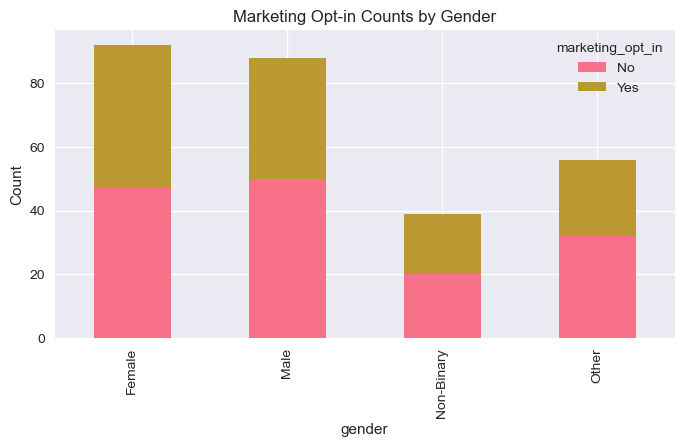

In [856]:
marketing_by_gender = (
    customers.groupby(['gender', 'marketing_opt_in'])
    .size()
    .unstack(fill_value=0)
    .reset_index()
)

print("Marketing Opt-in by Gender:")
display(marketing_by_gender)

marketing_by_gender.plot(
    x='gender', kind='bar', stacked=True, figsize=(8,4),
    title='Marketing Opt-in Counts by Gender'
)
plt.ylabel('Count')
plt.show()


#### Age summary: min, max, mean, median, null count

In [857]:
missing_ages = customers['age_source'] == 'Imputed'
unusual_count = customers['age_cleaned'].apply(lambda x: isinstance(x, str) and x.startswith("UNUSUAL")).sum()
numeric_age = customers['age_cleaned'].apply(lambda x: x if isinstance(x, int) else np.nan)

summary_stats = pd.DataFrame({
    'Min': [int(numeric_age.min())],
    'Max': [int(numeric_age.max())],
    'Mean': [round(numeric_age.mean(), 1)],
    'Median': [int(numeric_age.median())],
    'Missing Count': [sum(missing_ages)],
    'Unusual Count': [unusual_count]
})

display(summary_stats)

print("Missing Ages:")
display(customers.loc[missing_ages, ['customer_id','email', 'age', 'age_cleaned', 'age_source']])

unusual_ages = customers[customers['age_source'] == 'Unusual']
print("\nUnusual Ages:")
display(unusual_ages[['customer_id', 'age', 'age_cleaned', 'age_source']])

,Min,Max,Mean,Median,Missing Count,Unusual Count
0,21,60,35.4,34,18,1


Missing Ages:


,customer_id,email,age,age_cleaned,age_source
21,CUST00021,suzanne21@mailhub.org,NaN,34,Imputed
23,CUST00023,dawn23@example.com,NaN,34,Imputed
33,CUST00033,jodi33mailhub.org,NaN,34,Imputed
37,CUST00037,thomas37@inboxmail.net,NaN,34,Imputed
40,CUST00040,mary40@mailhub.org,NaN,34,Imputed
53,CUST00053,rebecca53@inboxmail.net,NaN,34,Imputed
56,CUST00056,brian56@mailhub.org,NaN,34,Imputed
76,CUST00076,dalton76@example.com,NaN,34,Imputed
88,CUST00088,paula88@inboxmail.net,NaN,34,Imputed
108,CUST00108,NaN,NaN,34,Imputed



Unusual Ages:


,customer_id,age,age_cleaned,age_source
204,CUST00204,206,UNUSUAL_206,Unusual


### Stretch Task

##### Load and Inspect Support Tickets

In [858]:
tickets['customer_id'] = tickets['customer_id'].astype(str).str.strip()

tickets['ticket_date'] = pd.to_datetime(tickets['ticket_date'], errors='coerce')

print(f"Support tickets: {tickets.shape}")
tickets.head()

Support tickets: (123, 5)


,ticket_id,customer_id,ticket_date,issue_type,resolved
0,TKT0000-1,CUST00203,2024-08-17,Billing,Yes
1,TKT0000-2,CUST00203,2024-07-22,Technical Error,Yes
2,TKT0000-3,CUST00203,2024-07-22,Other,Yes
3,TKT0001-1,CUST00266,2024-09-26,Account Setup,Yes
4,TKT0001-2,CUST00266,2024-10-09,Technical Error,No


##### Merge Customers with Support Tickets

In [859]:
customer_tickets = pd.merge(
    customers[['customer_id', 'signup_date', 'plan_selected', 'region']],
    tickets[['customer_id', 'ticket_date']],
    on='customer_id',
    how='inner' 
)
customer_tickets.head()

,customer_id,signup_date,plan_selected,region,ticket_date
0,CUST00005,2024-06-01,Premium,South,2024-06-04
1,CUST00007,2024-08-01,Pro,Central,2024-08-07
2,CUST00007,2024-08-01,Pro,Central,2024-08-23
3,CUST00009,2024-10-01,Premium,East,2024-10-03
4,CUST00017,2024-01-18,Pro,East,2024-02-03


##### Count how many customers contacted support within 2 weeks of sign-up

In [860]:
customer_tickets['days_since_signup'] = (customer_tickets['ticket_date'] - customer_tickets['signup_date']).dt.days

tickets_within_2weeks = customer_tickets[customer_tickets['days_since_signup'] <= 14]

num_customers_within_2weeks = tickets_within_2weeks['customer_id'].nunique()

print(f"Number of customers who contacted support within 2 weeks of signup: {num_customers_within_2weeks}")


Number of customers who contacted support within 2 weeks of signup: 47


##### Summarise support activity by plan and region (Group by plan and region)

,plan_selected,region,total_tickets,tickets_within_2weeks,unique_customers
0,Basic,Central,2,2,1
1,Basic,East,11,6,6
2,Basic,North,3,2,2
3,Basic,South,14,9,6
4,Basic,Unknown,2,1,1
5,Basic,West,10,4,4
6,Premium,Central,6,4,2
7,Premium,East,1,1,1
8,Premium,North,6,3,2
9,Premium,South,2,1,2


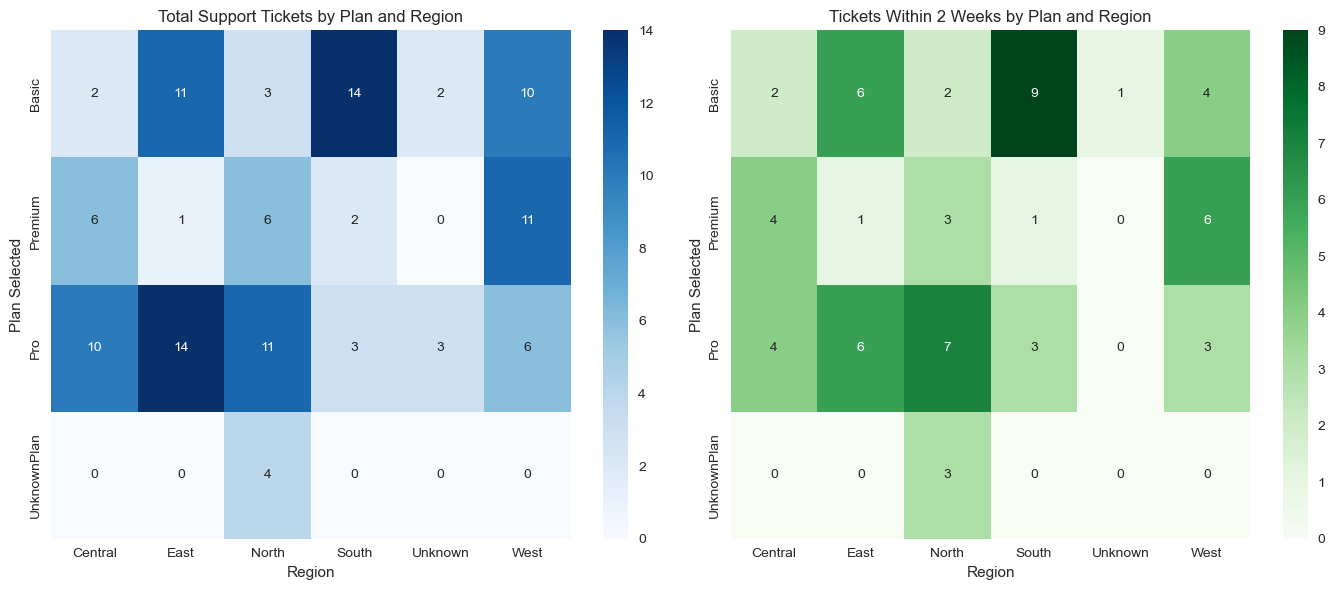

In [861]:
support_summary = (
    customer_tickets
    .groupby(['plan_selected', 'region'])
    .agg(
        total_tickets=('ticket_date', 'count'),
        tickets_within_2weeks=('days_since_signup', lambda x: (x <= 14).sum()),
        unique_customers=('customer_id', 'nunique')
    )
    .reset_index()
)

display(support_summary)

pivot_total = support_summary.pivot(index='plan_selected', columns='region', values='total_tickets').fillna(0)
pivot_2weeks = support_summary.pivot(index='plan_selected', columns='region', values='tickets_within_2weeks').fillna(0)

plt.figure(figsize=(14,6))

plt.subplot(1,2,1)
sns.heatmap(pivot_total, annot=True, fmt='.0f', cmap='Blues')
plt.title("Total Support Tickets by Plan and Region")
plt.ylabel("Plan Selected")
plt.xlabel("Region")

plt.subplot(1,2,2)
sns.heatmap(pivot_2weeks, annot=True, fmt='.0f', cmap='Greens')
plt.title("Tickets Within 2 Weeks by Plan and Region")
plt.ylabel("Plan Selected")
plt.xlabel("Region")

plt.tight_layout()
plt.show()

### Business Question Answers

#### 1. Which acquisition source brought in the most users last month?

source
Google       3
Instagram    2
Referral     1
Facebook     1
LinkedIn     1
Name: count, dtype: int64


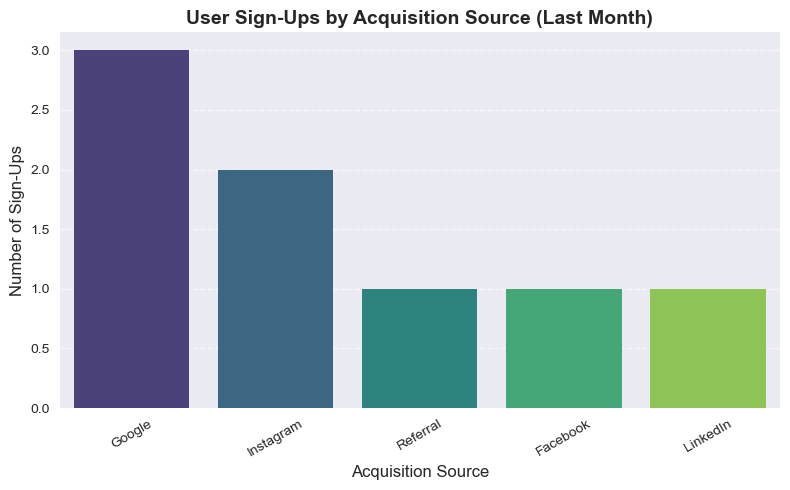

In [862]:
last_month_end = customers['signup_date'].max().replace(day=1) - pd.DateOffset(days=1)
last_month_start = last_month_end.replace(day=1)

recent_signups = customers[
    (customers['signup_date'] >= last_month_start) &
    (customers['signup_date'] <= last_month_end)
]

source_counts = recent_signups['source'].value_counts()
print(source_counts)

plt.figure(figsize=(8,5))
sns.barplot(
   x=source_counts.index,
    y=source_counts.values,
    palette="viridis",
    hue=source_counts.index,
    legend=False
)
plt.title("User Sign-Ups by Acquisition Source (Last Month)", fontsize=14, weight='bold')
plt.xlabel("Acquisition Source", fontsize=12)
plt.ylabel("Number of Sign-Ups", fontsize=12)
plt.xticks(rotation=30)
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()


#### 2. Which region shows signs of missing or incomplete data?

Average Missing Fields per User by Region:


region
North      0.430769
West       0.413043
East       0.393443
Unknown    0.333333
Central    0.307692
South      0.271186
Name: missing_fields, dtype: float64

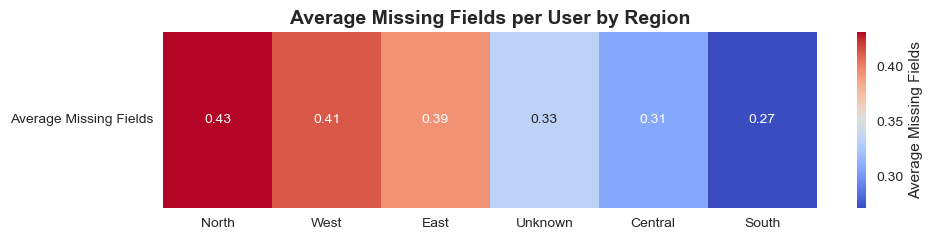

In [863]:
customers['missing_fields'] = customers.isna().sum(axis=1)

region_missing_summary = (
    customers.groupby('region')['missing_fields']
    .mean()
    .sort_values(ascending=False)
)

print("Average Missing Fields per User by Region:")
display(region_missing_summary)

heatmap_data = region_missing_summary.to_frame(name='Average Missing Fields').T

plt.figure(figsize=(10, 2.5))
sns.heatmap(heatmap_data, annot=True, cmap='coolwarm', fmt=".2f", cbar_kws={'label': 'Average Missing Fields'})
plt.title("Average Missing Fields per User by Region", fontsize=14, weight='bold')
plt.xlabel("")
plt.ylabel("")
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()



#### 3. Are older users more or less likely to opt in to marketing?

marketing_opt_in,No,Yes
age_group,,
16-25,0.569444,0.430556
26-35,0.537736,0.462264
36-45,0.510204,0.489796
46-55,0.510638,0.489362
56-65,0.571429,0.428571
66+,0.000000,0.000000


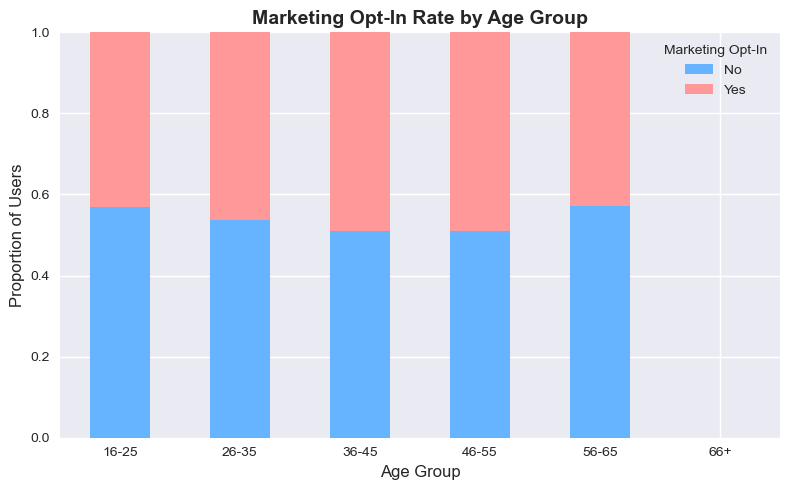

In [864]:
marketing_by_age = customers[customers['age_source'] != 'Unusual'].copy()
marketing_by_age['age_group'] = pd.cut(marketing_by_age['age_cleaned'], bins=[16,25,35,45,55,65,100], labels=['16-25','26-35','36-45','46-55','56-65','66+'])

opt_in_counts = marketing_by_age.groupby('age_group', observed=False)['marketing_opt_in'].value_counts(normalize=True).unstack(fill_value=0)
display(opt_in_counts)

ax = opt_in_counts.plot(
    kind='bar',
    stacked=True,
    figsize=(8,5),
    color=['#66b3ff','#ff9999']
)

plt.title("Marketing Opt-In Rate by Age Group", fontsize=14, weight='bold')
plt.xlabel("Age Group", fontsize=12)
plt.ylabel("Proportion of Users", fontsize=12)
plt.legend(title="Marketing Opt-In", labels=['No','Yes'])
plt.xticks(rotation=0)
plt.ylim(0,1)
plt.tight_layout()
plt.show()


#### 4. Which plan is most commonly selected, and by which age group?

age_group,16-25,26-35,36-45,46-55,56-65,66+
plan_selected,,,,,,
Basic,28,33,11,14,5,0
Premium,23,35,23,15,4,0
Pro,24,36,13,17,4,0
UnknownPlan,0,2,2,2,0,0


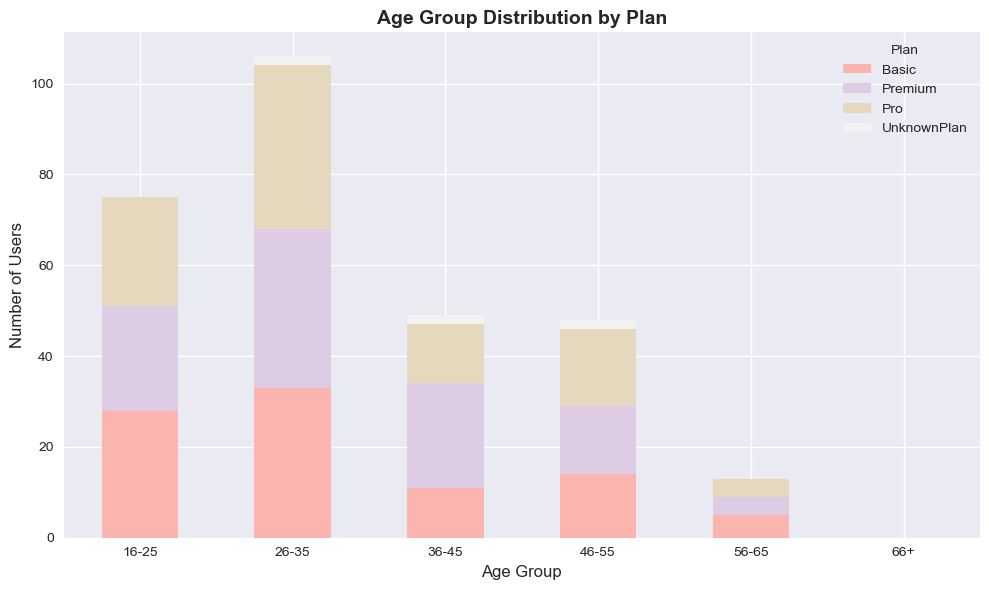

In [865]:
plan_age = customers[customers['age_source'] != 'Unusual'].copy()
plan_age['age_group'] = pd.cut(plan_age['age_cleaned'], bins=[16,25,35,45,55,65,100], labels=['16-25','26-35','36-45','46-55','56-65','66+'])

plan_age_counts = plan_age.groupby(['plan_selected','age_group'], observed=False).size().unstack(fill_value=0)
display(plan_age_counts)

plan_age_counts.T.plot(
    kind='bar', 
    stacked=True, 
    figsize=(10,6), 
    colormap='Pastel1'
)

plt.title("Age Group Distribution by Plan", fontsize=14, weight='bold')
plt.xlabel("Age Group", fontsize=12)
plt.ylabel("Number of Users", fontsize=12)
plt.xticks(rotation=0)
plt.legend(title="Plan")
plt.tight_layout()
plt.show()


#### 5. Which plan’s users are most likely to contact support?

plan_selected
Pro            24
Basic          20
Premium        12
UnknownPlan     2
Name: customer_id, dtype: int64

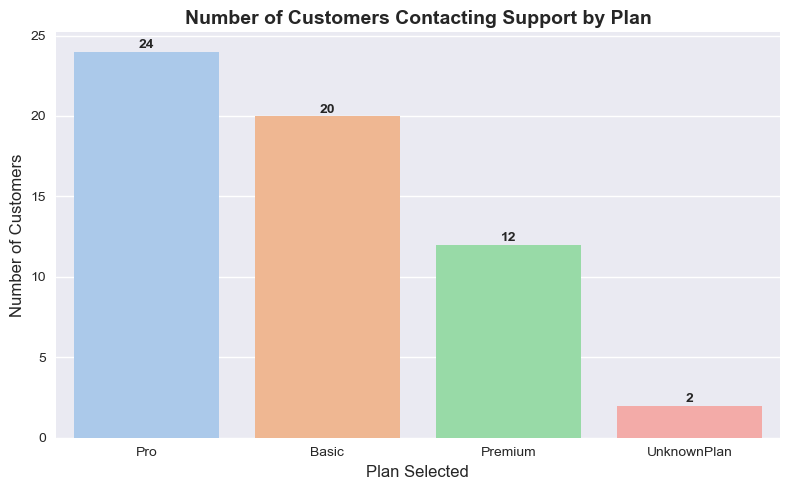

In [866]:
support_by_plan = customer_tickets.groupby('plan_selected')['customer_id'].nunique()
support_by_plan = support_by_plan.sort_values(ascending=False)
display(support_by_plan)

plt.figure(figsize=(8,5))
sns.barplot(
    x=support_by_plan.index, 
    y=support_by_plan.values, 
    palette='pastel',
    hue=support_by_plan.index,
    legend=False
)
plt.title("Number of Customers Contacting Support by Plan", fontsize=14, weight='bold')
plt.xlabel("Plan Selected", fontsize=12)
plt.ylabel("Number of Customers", fontsize=12)
for i, v in enumerate(support_by_plan.values):
    plt.text(i, v + 0.2, str(v), ha='center', fontweight='bold')
plt.tight_layout()
plt.show()
